### Fasttext --> Feedforward Neural Network

In [3]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
valid = pd.read_csv("valid.csv")

train.loc[train["review_score"]==-1, "review_score"]=0
test.loc[test["review_score"]==-1, "review_score"]=0
valid.loc[valid["review_score"]==-1, "review_score"]=0

Loading a pretrained model with English word embeddings (https://fasttext.cc/docs/en/crawl-vectors.html):

In [4]:
from gensim.models.fasttext import load_facebook_model

vectors_file = "cc.en.300.bin"
fb_model = load_facebook_model(vectors_file)

fb_model.wv.get_sentence_vector("Good game")

array([ 1.78246237e-02, -1.06189400e-01, -2.44729444e-02, -2.21012142e-02,
        1.59936324e-02,  3.34691778e-02, -1.06833659e-01, -3.30949295e-03,
       -2.14542568e-04,  1.48508116e-03, -2.93094777e-02, -2.15188637e-02,
        3.55641954e-02,  2.25957129e-02,  2.12054476e-02,  4.47175875e-02,
       -5.20626409e-03,  5.60886189e-02,  1.39281712e-02,  3.23922932e-02,
        2.46591270e-02,  9.72066727e-03, -8.12041387e-03, -4.68677804e-02,
        3.57795991e-02, -3.31927240e-02,  1.93208049e-04, -2.41375212e-02,
        1.56584624e-02,  9.49325413e-02,  3.46111394e-02, -1.00905932e-02,
        4.39240132e-03,  2.39842106e-02,  1.37603339e-02, -4.40947488e-02,
        7.08558830e-03,  8.42494331e-03,  7.17797317e-03,  7.57907005e-03,
        2.67372504e-02, -3.01967952e-02, -4.28102091e-02,  2.58105062e-02,
        5.47624193e-02,  5.96127613e-03, -1.95893943e-02,  4.33259085e-02,
       -2.37351451e-02,  8.60271696e-03,  5.02952486e-02, -1.85346920e-02,
        4.15457152e-02,  

In [5]:
from numpy.linalg import norm
def cosine_similarity(a, b):
    return np.dot(a,b)/(norm(a)*norm(b))

def get_sentence_similarity(sent_a, sent_b):
    vec1 = fb_model.wv.get_sentence_vector(sent_a)
    vec2 = fb_model.wv.get_sentence_vector(sent_b)
    return cosine_similarity(vec1,vec2)

print(get_sentence_similarity("Good game", "Amazing game, I love it!"))
print(get_sentence_similarity("Good game", "Horrible game. A buggy mess."))

0.9303907
0.94947904


In [6]:
train["vectorized"] = train["review_text"].apply(lambda x : fb_model.wv.get_sentence_vector(x))

In [7]:
train.iloc[0]["vectorized"]

array([ 8.71886499e-03, -9.33922902e-02, -3.61323059e-02, -2.44729072e-02,
        1.08409366e-02,  1.93068106e-02, -8.36923420e-02,  2.29316903e-03,
       -1.35135755e-03,  2.88301776e-03, -2.74441373e-02, -9.83558595e-03,
        3.87936011e-02,  9.47409403e-03,  3.30047533e-02,  4.45564575e-02,
        8.05891701e-04,  4.50393967e-02,  3.19698919e-03,  2.77824774e-02,
       -4.72737849e-03,  1.12508880e-02,  2.10752850e-03, -1.86015293e-02,
        2.95459442e-02, -1.79125778e-02, -9.69705731e-03, -1.25571457e-03,
        6.71224575e-03,  9.82025936e-02,  2.62354501e-02,  4.77575843e-04,
        4.30168724e-03,  2.30760872e-02,  7.46196136e-03, -2.56011821e-02,
        2.26500910e-03,  9.29989759e-03,  4.85312892e-03, -2.05451786e-03,
        1.66831594e-02, -4.36836779e-02, -3.61202359e-02,  1.47827193e-02,
        4.84717675e-02,  2.09881645e-02, -1.83120575e-02,  3.67828794e-02,
       -2.54551638e-02,  5.68488985e-03,  3.21363397e-02, -1.92501992e-02,
        3.51247750e-02,  

In [8]:
test["vectorized"] = test["review_text"].apply(lambda x : fb_model.wv.get_sentence_vector(x))
valid["vectorized"] = valid["review_text"].apply(lambda x : fb_model.wv.get_sentence_vector(x))

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam

def create_model():
    inputs = keras.Input(shape=(300,))
    dense1 = layers.Dense(256, activation="relu")(inputs)
    dense2 = layers.Dense(128, activation="relu")(dense1)
    dense3 = layers.Dense(64, activation="relu")(dense2)
    output = layers.Dense(1, activation="sigmoid")(dense3)
    model = keras.Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
    return model

In [10]:
train_x = np.stack(train["vectorized"].values)
train_y = np.stack(train["review_score"].values)

valid_x = np.stack(valid["vectorized"].values)
valid_y = np.stack(valid["review_score"].values)

test_x = np.stack(test["vectorized"].values)
test_y = np.stack(test["review_score"].values)

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model = create_model()
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=25, callbacks=[callback])

Epoch 1/25
1351/1351 [==============================] - 3s 1ms/step - loss: 0.6815 - accuracy: 0.5627 - val_loss: 0.6221 - val_accuracy: 0.7079
Epoch 2/25
1351/1351 [==============================] - 2s 1ms/step - loss: 0.6564 - accuracy: 0.6112 - val_loss: 0.6649 - val_accuracy: 0.5497
Epoch 3/25
1351/1351 [==============================] - 2s 1ms/step - loss: 0.6492 - accuracy: 0.6204 - val_loss: 0.6619 - val_accuracy: 0.5553
Epoch 4/25
1351/1351 [==============================] - 2s 1ms/step - loss: 0.6439 - accuracy: 0.6280 - val_loss: 0.6552 - val_accuracy: 0.5702
Epoch 5/25
1351/1351 [==============================] - 2s 1ms/step - loss: 0.6405 - accuracy: 0.6333 - val_loss: 0.6135 - val_accuracy: 0.6346
Epoch 6/25
1351/1351 [==============================] - 2s 1ms/step - loss: 0.6374 - accuracy: 0.6352 - val_loss: 0.7130 - val_accuracy: 0.4843
Epoch 7/25
1351/1351 [==============================] - 2s 1ms/step - loss: 0.6348 - accuracy: 0.6409 - val_loss: 0.6140 - val_accuracy:

In [12]:
def create_model():
    inputs = keras.Input(shape=(300,))
    dense1 = layers.Dense(1024, activation="relu")(inputs)
    dense2 = layers.Dense(512, activation="relu")(dense1)
    dense3 = layers.Dense(128, activation="relu")(dense2)
    output = layers.Dense(1, activation="sigmoid")(dense3)
    model = keras.Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
    return model

In [14]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model = create_model()
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=25, callbacks=[callback])

Epoch 1/25
1351/1351 [==============================] - 3s 2ms/step - loss: 0.6707 - accuracy: 0.5788 - val_loss: 0.6569 - val_accuracy: 0.5608
Epoch 2/25
1351/1351 [==============================] - 2s 2ms/step - loss: 0.6493 - accuracy: 0.6180 - val_loss: 0.8048 - val_accuracy: 0.3736
Epoch 3/25
1351/1351 [==============================] - 2s 2ms/step - loss: 0.6426 - accuracy: 0.6281 - val_loss: 0.6285 - val_accuracy: 0.6160
Epoch 4/25
1351/1351 [==============================] - 2s 2ms/step - loss: 0.6376 - accuracy: 0.6348 - val_loss: 0.6405 - val_accuracy: 0.5911
Epoch 5/25
1351/1351 [==============================] - 3s 2ms/step - loss: 0.6328 - accuracy: 0.6406 - val_loss: 0.6520 - val_accuracy: 0.5826
Epoch 6/25
1351/1351 [==============================] - 2s 2ms/step - loss: 0.6283 - accuracy: 0.6458 - val_loss: 0.6654 - val_accuracy: 0.5612
Epoch 7/25
1351/1351 [==============================] - 3s 2ms/step - loss: 0.6251 - accuracy: 0.6484 - val_loss: 0.6713 - val_accuracy:

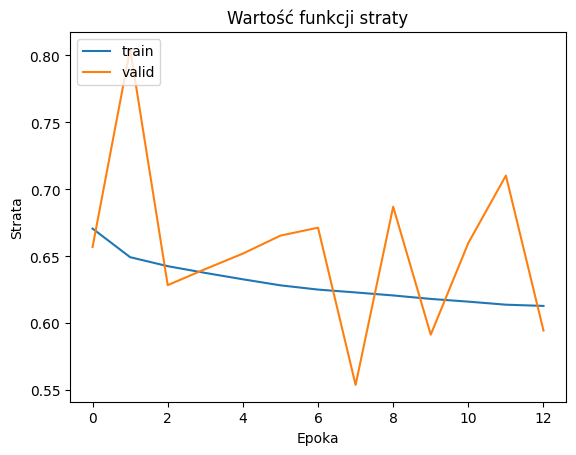

In [30]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wartość funkcji straty')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['train', 'valid'], loc='upper left')

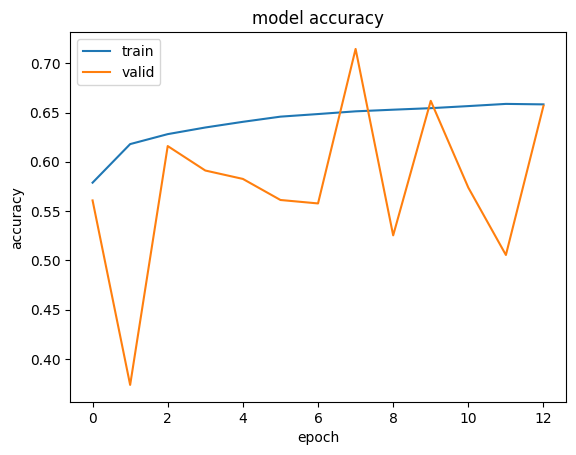

In [31]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

In [15]:
model.save("fasttext_model.keras")

### Despite several attempts at fine-tuning model parameters, it seems that the prediction quality is quite low. Despite this, the model appears overfit? 

(accuracy / loss for the validation dataset is jumping despite the training curve being steady)

In [18]:
import tensorflow as tf
def test_review_text(sentence):
    vectorized = fb_model.wv.get_sentence_vector(sentence)
    reshaped = tf.reshape(vectorized,shape=(1,300))
    #print(vectorized.shape)
    score = float(model(reshaped))
    score_rounded = round(score)
    print(score)
    if score_rounded==0:
        print("Negative review")
    else:
        print("Positive review")

In [19]:
test_review_text("A buggy, uninspired mess")

0.7820833921432495
Positive review


In [20]:
test_review_text("This game is bad")

0.44321733713150024
Negative review


In [21]:
test_review_text("This game destroyed my life")

0.8973167538642883
Positive review


In [22]:
test_review_text("Best game I've ever played")

0.8987871408462524
Positive review


In [23]:
test_review_text("Fun cooperative play with scalable difficulty. Rapid path to get into a game with friends or open public games. ")

0.5772996544837952
Positive review


In [24]:
test_review_text("Deliriously buggy. Fun if/when it works properly. Wait and see if they actually QA the next few patches before you play.")

0.6418458819389343
Positive review


In [25]:
test["model_predictions"] = model(np.stack(test["vectorized"].values))

In [26]:
test["model_predictions"] = test["model_predictions"].apply(lambda x : round(float(x)))

In [27]:
def get_metrics():
    df = test
    predictions = df["model_predictions"].to_numpy()
    true_values = df["review_score"].to_numpy()
    accuracy = np.sum(np.rint(predictions) == true_values)/len(true_values)
    TN_count = len(df.query("`review_score`==0 and `model_predictions`==0").index)
    TP_count = len(df.query("`review_score`==1 and `model_predictions`==1").index)
    FP_count = len(df.query("`review_score`==0 and `model_predictions`==1").index)
    FN_count = len(df.query("`review_score`==1 and `model_predictions`==0").index)
    precision = TP_count/(TP_count+FP_count)
    recall = TP_count/(TP_count+FN_count)
    F1_score = (2*precision*recall)/(precision+recall)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {F1_score:.2f}")
get_metrics()

Accuracy: 0.72
Precision: 0.89
Recall: 0.76
F1 Score: 0.82


It's possible that the model's results would be better if the word embeddings were trained on game reviews in particular, and not general English texts which don't use the specific type of slang that Steam reviews often do.